# Demand Forecasting


In [1]:
# Store Item Demand Forecasting Challenge
# https://www.kaggle.com/c/demand-forecasting-kernels-only
!pip install lightgbm
# conda install lightgbm

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


Loading the data


In [11]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/test.csv', parse_dates=['date'])



df = pd.concat([train, test], sort=False)


In [12]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1.0,1.0,13.0,NaN
1,2013-01-02,1.0,1.0,11.0,NaN
2,2013-01-03,1.0,1.0,14.0,NaN
3,2013-01-04,1.0,1.0,13.0,NaN
4,2013-01-05,1.0,1.0,10.0,NaN


# EDA


In [14]:

check_df(df)


##################### Shape #####################
(1016040, 5)
##################### Types #####################
date      object
store    float64
item     float64
sales    float64
id       float64
dtype: object
##################### Head #####################
         date  store  item  sales  id
0  2013-01-01    1.0   1.0   13.0 NaN
1  2013-01-02    1.0   1.0   11.0 NaN
2  2013-01-03    1.0   1.0   14.0 NaN
3  2013-01-04    1.0   1.0   13.0 NaN
4  2013-01-05    1.0   1.0   10.0 NaN
##################### Tail #####################
                      date  store  item  sales       id
44995  2018-03-27 00:00:00   10.0  50.0    NaN  44995.0
44996  2018-03-28 00:00:00   10.0  50.0    NaN  44996.0
44997  2018-03-29 00:00:00   10.0  50.0    NaN  44997.0
44998  2018-03-30 00:00:00   10.0  50.0    NaN  44998.0
44999  2018-03-31 00:00:00   10.0  50.0    NaN  44999.0
##################### NA #####################
date          0
store         1
item          1
sales     45001
id       971040

In [15]:

df[["store"]].nunique()



store    10
dtype: int64

In [16]:
df[["item"]].nunique()


item    50
dtype: int64

In [17]:

df.groupby(["store"])["item"].nunique()



store
1.0     50
2.0     50
3.0     50
4.0     50
5.0     50
6.0     50
7.0     50
8.0     50
9.0     50
10.0    50
Name: item, dtype: int64

In [18]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})


sales
                 sum
store item          
1.0   1.0    36468.0
      2.0    97050.0
      3.0    60638.0
      4.0    36440.0
      5.0    60670.0
...              ...
10.0  46.0  120601.0
      47.0   45204.0
      48.0  105570.0
      49.0   60317.0
      50.0  135192.0

[500 rows x 1 columns]

In [19]:

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})



sales                             
                 sum       mean median        std
store item                                       
1.0   1.0    36468.0  19.971522   19.0   6.741022
      2.0    97050.0  53.148959   52.0  15.005779
      3.0    60638.0  33.208105   33.0  10.072529
      4.0    36440.0  19.956188   20.0   6.640618
      5.0    60670.0  16.612815   16.0   5.671326
...              ...        ...    ...        ...
10.0  46.0  120601.0  66.046550   65.0  18.114991
      47.0   45204.0  24.755750   24.0   7.924820
      48.0  105570.0  57.814896   57.0  15.898538
      49.0   60317.0  33.032311   32.0  10.091610
      50.0  135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [20]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1.0,1.0,13.0,NaN
1,2013-01-02,1.0,1.0,11.0,NaN
2,2013-01-03,1.0,1.0,14.0,NaN
3,2013-01-04,1.0,1.0,13.0,NaN
4,2013-01-05,1.0,1.0,10.0,NaN


In [25]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

#FEATURE ENGINEERING


In [26]:
df.head()

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})



sales                             
                      sum       mean median        std
store item month                                      
1.0   1.0  1.0     2125.0  13.709677   13.0   4.397413
           2.0     2063.0  14.631206   14.0   4.668146
           3.0     2728.0  17.600000   17.0   4.545013
           4.0     3118.0  20.786667   20.0   4.894301
           5.0     3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10.0  50.0 8.0    13108.0  84.567742   85.0  15.676527
           9.0    11831.0  78.873333   79.0  15.207423
           10.0   11322.0  73.045161   72.0  14.209171
           11.0   11549.0  76.993333   77.0  16.253651
           12.0    8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

Random Noise


In [27]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


Lag/Shifted Features


**Burada değeri 91 den başlatmamızın sebebi aslında bu bir kaggle yarışması ve bize test seti 3 aylık olduğundan 91 lik başlattık kaç aylık tahmın yapıcaksan onunla başlat ve etrafına eklemeye başla**

In [36]:
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [28]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

df.groupby(["store", "item"])['sales'].head()

df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(1016040, 24)
##################### Types #####################
date              datetime64[ns]
store                    float64
item                     float64
sales                    float64
id                       float64
month                    float64
day_of_month             float64
day_of_year              float64
week_of_year             float64
day_of_week              float64
year                     float64
is_wknd                  float64
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sale

Rolling Mean Features





In [29]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

Exponentially Weighted Mean Features


In [30]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(1016040, 71)
##################### Types #####################
date                          datetime64[ns]
store                                float64
item                                 float64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week    year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  s

One-Hot Encoding


In [31]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month']) # Bizim için çok onemliler get dummiesliyoruz


check_df(df)


##################### Shape #####################
(1016040, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month           float64
day_of_year            float64
                     ...      
month_8.0                uint8
month_9.0                uint8
month_10.0               uint8
month_11.0               uint8
month_12.0               uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year    year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

Converting sales to log(1+sales)


In [32]:
df['sales'] = np.log1p(df["sales"].values) #Skewness

check_df(df)

##################### Shape #####################
(1016040, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month           float64
day_of_year            float64
                     ...      
month_8.0                uint8
month_9.0                uint8
month_10.0               uint8
month_11.0               uint8
month_12.0               uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year    year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095

# Model


Custom Cost Function


In [33]:
# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False




Time-Based Validation Sets


In [37]:
train
test

#   Burada modelimiz performasını değerlendirmeden önce trainimizi test ve vala bölüyoruz
#   val'ıda gerçekliği yansıtsın diye aynı test setinde olduğu gibi 3 ay olacak şekilde oluşturuyoruz

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]] #HALİ HAZIRDA DELİ GİBİ FEAURE ÜRETTIK O YUZDEN SİLİYORUZ

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((776859,), (776859, 142), (47880,), (47880, 142))

#LightGBM ile Zaman Serisi Modeli

##Burada herhangi bir hyperparameter optimizasyonu yapılmamıştır ama sen yapıcaksın

In [44]:
!pip install lightgbm
# conda install lightgbm

from lightgbm import early_stopping
from lightgbm import log_evaluation
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape,
                  callbacks=[log_evaluation(100),early_stopping(100,verbose=False)],
                 ) # removing this line prints a lot of evaluation info that I want to remove

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.557999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[100]	training's l2: 0.0544908	training's SMAPE: 18.1182	valid_1's l2: 0.0556583	valid_1's SMAPE: 17.8323
[200]	training's l2: 0.0368781	training's SMAPE: 14.9106	valid_1's l2: 0.0385653	valid_1's SMAPE: 15.1759
[300]	training's l2: 0.0337699	training's SMAPE: 14.3053	valid_1's l2: 0.0358338	valid_1's SMAPE: 14.7803
[400]	training's l2: 0.0325325	training's SMAPE: 14.0465	valid_1's l2: 0.034739	valid_1's SMAPE: 14.5735
[500]	training's l2: 0.0317489	training's SMAPE: 13.887	valid_1's l2: 0.0340694	valid_1's SMAPE: 14.421
[600]	training's l2: 0.0312322	training's SMAPE: 13.784	valid_1's l2: 0.0336197	valid_1's SMAPE: 14.3201
[700]	training's l2: 0.0308653	training's SMAPE: 13.7087	valid_1's l2: 0.033288	valid_1's SMAPE: 14.2411
[800]	training's l2: 0.0305479	training's SMAPE: 13.6476	valid_1's l2: 0.0330731	valid_1's SMAPE: 

14.118407561593154

In [53]:
y_pred_val

array([2.98757799, 2.49286255, 2.63298176, ..., 4.27440521, 4.37334291,
       4.43976994])

# Değişken Önem Düzeyleri


In [45]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp



In [46]:

plot_lgb_importances(model, num=200)



                        feature  split       gain
17          sales_roll_mean_546    735  53.152065
13                sales_lag_364   1059  10.910949
16          sales_roll_mean_365    601  10.403286
1                   day_of_year    896   3.385245
18   sales_ewm_alpha_095_lag_91     90   2.849457
..                          ...    ...        ...
111                   item_39.0      0   0.000000
74                     item_2.0      0   0.000000
115                   item_43.0      0   0.000000
118                   item_46.0      0   0.000000
71                    store_9.0      0   0.000000

[142 rows x 3 columns]


,feature,split,gain
17,sales_roll_mean_546,735,53.152065
13,sales_lag_364,1059,10.910949
16,sales_roll_mean_365,601,10.403286
1,day_of_year,896,3.385245
18,sales_ewm_alpha_095_lag_91,90,2.849457
...,...,...,...
111,item_39.0,0,0.000000
74,item_2.0,0,0.000000
115,item_43.0,0,0.000000
118,item_46.0,0,0.000000


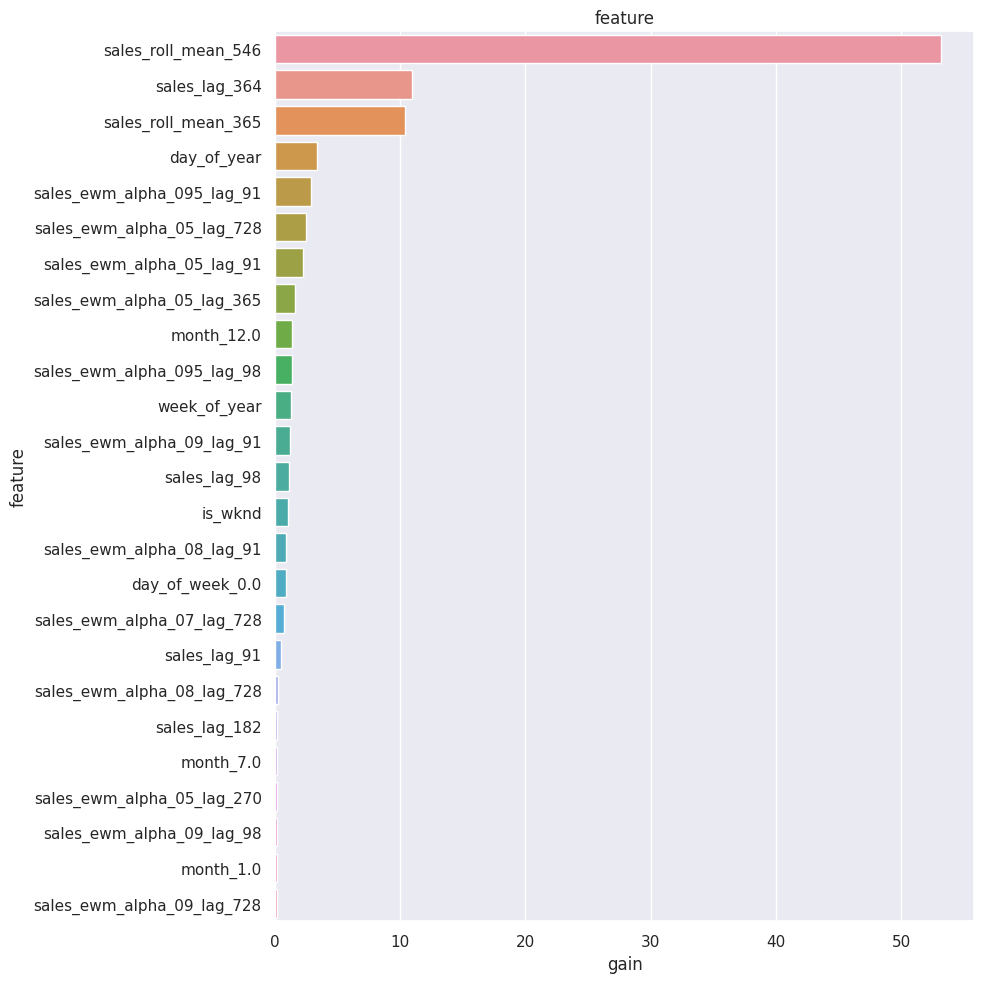

,feature,split,gain
17,sales_roll_mean_546,735,53.152065
13,sales_lag_364,1059,10.910949
16,sales_roll_mean_365,601,10.403286
1,day_of_year,896,3.385245
18,sales_ewm_alpha_095_lag_91,90,2.849457
...,...,...,...
111,item_39.0,0,0.000000
74,item_2.0,0,0.000000
115,item_43.0,0,0.000000
118,item_46.0,0,0.000000


In [47]:
plot_lgb_importances(model, num=30, plot=True)



In [48]:

feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

                        feature  split       gain
17          sales_roll_mean_546    735  53.152065
13                sales_lag_364   1059  10.910949
16          sales_roll_mean_365    601  10.403286
1                   day_of_year    896   3.385245
18   sales_ewm_alpha_095_lag_91     90   2.849457
..                          ...    ...        ...
111                   item_39.0      0   0.000000
74                     item_2.0      0   0.000000
115                   item_43.0      0   0.000000
118                   item_46.0      0   0.000000
71                    store_9.0      0   0.000000

[142 rows x 3 columns]


115

#Final Model


In [49]:
# Eğer zamandan kazanmak istersen cols yerine imp_feats yazabilirsin gain skoru 0 olan faetureları siler

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.485929 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [54]:
test_preds

array([2.53992364, 2.67512498, 2.74453651, ..., 4.42904085, 4.49145812,
       3.39281993])

Submission File


In [56]:
test.head()


,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1.0,store_2.0,store_3.0,store_4.0,store_5.0,store_6.0,store_7.0,store_8.0,store_9.0,store_10.0,item_1.0,item_2.0,item_3.0,item_4.0,item_5.0,item_6.0,item_7.0,item_8.0,item_9.0,item_10.0,item_11.0,item_12.0,item_13.0,item_14.0,item_15.0,item_16.0,item_17.0,item_18.0,item_19.0,item_20.0,item_21.0,item_22.0,item_23.0,item_24.0,item_25.0,item_26.0,item_27.0,item_28.0,item_29.0,item_30.0,item_31.0,item_32.0,item_33.0,item_34.0,item_35.0,item_36.0,item_37.0,item_38.0,item_39.0,item_40.0,item_41.0,item_42.0,item_43.0,item_44.0,item_45.0,item_46.0,item_47.0,item_48.0,item_49.0,item_50.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
0,2018-01-01,NaN,0.0,1.0,1.0,1.0,2018.0,0.0,1,0,11.195224,13.261750,24.832195,14.002424,13.392377,14.581778,17.868445,14.609050,20.126840,14.090694,25.431752,21.166649,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2.0,2.0,1.0,2018.0,0.0,0,0,19.088357,17.859444,21.095502,20.181113,26.545150,22.581121,24.607237,6.975251,30.049720,12.814951,24.733737,21.921173,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3.0,3.0,1.0,2018.0,0.0,0,0,13.892001,26.883551,22.582630,15.427523,24.443896,23.681414,23.718874,16.173209,20.57233

In [67]:

submission_df = test.loc[:, ["id","sales"]]
submission_df['sales'] = np.expm1(test_preds)
submission_df = submission_df[pd.to_numeric(submission_df['id'], errors='coerce').notna()]
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission_demand.csv", index=False)

In [69]:
submission_df.head()

,id,sales
0,0,11.678703
1,1,13.514164
2,2,14.557402
3,3,14.650311
4,4,16.669021
